In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
# Learner and Runner
from functools import partial
from pathlib import Path
from torch.nn import init
from torch.utils.data import TensorDataset
from torch import nn
import pandas as pd
import torch.nn.functional as F
import torch
from dltools.callback import AvgStatsCallback, sched_lin, sched_cos, Recorder, ParamScheduler, combine_scheds
from dltools.callback import Callback, LearningrateFinder, DeviceCallback, BatchTransformXCallback
from dltools.callback import TrainEvalCallback
from dltools.functions import activation_stats, create_learner, get_dls, get_model, get_model_func, listify
from dltools.functions import normalize, init_lin
from dltools.functions import proc_df, normalize_to
from dltools.data import TypeSelector
from dltools.databunch import DataBunch
from dltools.hook import append_stats_hist, Hooks, telemetrize
from dltools.layer import lin_layer, lin_bn_layer, GeneralRelu
from dltools.learner import flatten, get_lin_model, get_lin_grelu_model, get_learn_run, get_runner, Runner
# from dltools.runner import flatten, get_lin_model, get_lin_grelu_model, get_learn_run, get_runner, Runner
from dltools.metrics import avg_deviation, rmsle
from matplotlib import pyplot as plt

In [2]:
# Only Learner
from functools import partial
from pathlib import Path
from torch.nn import init
from torch.utils.data import TensorDataset
from torch import nn
import pandas as pd
import torch.nn.functional as F
import torch
from dltools.callback import AvgStatsCallback, sched_lin, sched_cos, Recorder, ParamScheduler, combine_scheds
from dltools.callback import Callback, LearningrateFinder, DeviceCallback, BatchTransformXCallback
from dltools.callback import TrainEvalCallback
from dltools.functions import activation_stats, get_dls, get_model, get_model_func, listify
from dltools.functions import normalize, init_lin
from dltools.functions import proc_df, normalize_to
from dltools.data import TypeSelector
from dltools.databunch import DataBunch
from dltools.hook import append_stats_hist, Hooks, telemetrize
from dltools.layer import lin_layer, lin_bn_layer, GeneralRelu, LinLayer
from dltools.learner import flatten, get_lin_model, get_lin_grelu_model# , get_learn_run, get_runner
from dltools.metrics import avg_deviation, rmsle
from matplotlib import pyplot as plt

In [3]:
def get_data():
    PATH = Path('../data/houseprice/')
    df_train = pd.read_csv(PATH/'train.csv', sep=',', header=0)
    df_y = df_train['SalePrice']
    df_train.drop(['SalePrice'], axis=1, inplace=True)
    df_test = pd.read_csv(PATH/'test.csv', sep=',', header=0)

    cat_names = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
        'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
        'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

    cont_names = [name for name in df_train.columns if name not in cat_names]
    proc_train, proc_test = proc_df(cont_names, cat_names, df_train, df_test)

    x_train = torch.tensor(proc_train.values[:1168], dtype=torch.float32)
    y_train = torch.tensor(df_y.values[:1168], dtype=torch.float32) #.reshape(-1,1)
    x_valid = torch.tensor(proc_train.values[1168:], dtype=torch.float32)
    y_valid = torch.tensor(df_y.values[1168:], dtype=torch.float32) #.reshape(-1,1)
    x_test = torch.tensor(proc_test.values, dtype=torch.float32)

    return (x_train, y_train, x_valid, y_valid, x_test)

In [4]:
# !type housepricemanual.py

In [5]:
# !dir PATH

### Get data

In [6]:
torch.set_num_threads(2)

In [7]:
x_train, y_train, x_valid, y_valid, x_test = get_data()
x_train, x_valid, x_test = normalize_to(x_train, x_valid, x_test)

In [8]:
y_mean, y_std = y_train.mean(), y_train.std()
y_mean, y_std

(tensor(180590.2812), tensor(78815.6953))

In [9]:
# y_train, y_valid = normalize_to(y_train, y_valid)
y_train.mean(), y_train.std()

(tensor(180590.2812), tensor(78815.6953))

In [10]:
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)

In [11]:
x_train.mean(), x_train.std(), x_valid.mean(), x_valid.std(), y_train.mean(), y_train.std(), y_valid.mean(), y_valid.std()

(tensor(-1.0473e-07),
 tensor(1.),
 tensor(0.0027),
 tensor(0.8399),
 tensor(180590.2812),
 tensor(78815.6953),
 tensor(182244.8594),
 tensor(82026.8984))

In [12]:
bs = 64
loss_func = rmsle
c = 1 # Number of output classes
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [13]:
nh = [160, 80, 40, 20]
nh

[160, 80, 40, 20]

In [14]:
cbfs = [DeviceCallback, Recorder, partial(AvgStatsCallback, avg_deviation)]

### Init model

In [ ]:
model = get_lin_model(data, nh, lin_layer)
learn, run = get_runner(model, data, lr=0.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
x, y = next(iter(data.train_dl))

In [ ]:
x.mean(), x.std()

In [ ]:
# mean and std after first layer
p = model[0](x)
p.mean(), p.std()

In [ ]:
for l in model:
    print(l[0].weight.mean())

In [ ]:
# init model layers with kaiming
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [ ]:
# mean and std after first layer
p = model[0](x)
p.mean(), p.std()

### Learning rate finder

In [ ]:
cbfs = [Recorder, LearningrateFinder]

In [ ]:
model = get_lin_model(data, nh, lin_layer)

In [ ]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [ ]:
learn, run = get_runner(model, data, cbs=cbfs, loss_func = rmsle)

In [ ]:
run.fit(40, learn)

In [ ]:
run.recorder.plot(skip_last=5)

In [ ]:
# lr 0.25 looks ok

In [ ]:
run.recorder.plot_lr()

### Hook telemetry

#### Simple loop and plot

In [ ]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(4, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, hist = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, hist = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [ ]:
fig,axes = plt.subplots(1, 3, figsize=(12, 5))
for ax,h in zip(axes.flatten(), hooks[:3]):
    ax.imshow(get_hist(h), origin='lower')
plt.tight_layout()

In [ ]:
fig,axes = plt.subplots(1, 3, figsize=(10, 3))
for ax,h in zip(axes.flatten(), hooks[:3]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# the activations are so high because of the value range of the dependent variable.
# have to try normalizing y
# remark: normalizing y makes the gradients explode

In [ ]:
learn, run = get_runner(get_model_func(0.9), data)

In [ ]:
1%4

#### Histogram, proportion of 0, mean and std development

In [ ]:
model = get_lin_grelu_model(data, nh, 0.1, [0.4, 0.3, 0.3, 0.3], None, lin_bn_layer, bn=False)
# model

In [ ]:
learn, run = get_runner(model, data, lr=0.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
init_lin(model, True)

In [ ]:
activation_stats(model, data)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(8, learn)
    telemetrize(hooks, xlim=2*len(learn.data.train_ds)//bs)

### Batchnorm

#### Batchnorm 1 +++

In [ ]:
model = get_lin_grelu_model(data, nh, 0.1, [0.4, 0.3, 0.3, 0.3], None, lin_bn_layer, bn=False)

In [ ]:
learn, run = get_runner(model, data, lr=0.15, cbs=cbfs, loss_func = rmsle)

In [ ]:
init_lin(model, True)

In [ ]:
activation_stats(model, data)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(8, learn)
    telemetrize(hooks, xlim=2*len(learn.data.train_ds)//bs)

#### Batchnorm 2

In [ ]:
model = get_lin_grelu_model(data, nh, 0.0, 0.0, 0.0, lin_bn_layer)
model

In [ ]:
from dltools.layer import GeneralRelu

In [ ]:
model1 = nn.Sequential(
    nn.Sequential(
        nn.Linear(481, 160, False),
        GeneralRelu(0., 0., 0.),
        nn.BatchNorm1d(160)),
    nn.Sequential(
        nn.Linear(160, 80, False),
        GeneralRelu(0., 0., 0.),
        nn.BatchNorm1d(80)),
    nn.Sequential(
        nn.Linear(80, 40, False),
        GeneralRelu(0., 0., 0.),
        nn.BatchNorm1d(40)),
    nn.Sequential(
        nn.Linear(40, 20, False),
        GeneralRelu(0., 0., 0.),
        nn.BatchNorm1d(20)),
    nn.Linear(20, 1, True)
    )
model1

In [ ]:
learn, run = get_runner(model1, data, lr=0.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
with Hooks(model1, append_stats_hist) as hooks:
    run.fit(8, learn)
    # telemetrize(hooks, xlim=8*len(learn.data.train_ds)//bs)

#### Batchnorm 3

In [ ]:
model = get_lin_grelu_model(data, nh, 0.0, 0.0, None, lin_bn_layer, bn=False)
learn, run = get_runner(model, data, lr=0.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
model

In [ ]:
init_lin(model, True)

In [ ]:
activation_stats(model, data)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(8, learn)
    # telemetrize(hooks, xlim=2*len(learn.data.train_ds)//bs)

#### Batchnorm 4 fixing x values below 0

In [ ]:
x, y = next(iter(data.train_dl))

In [ ]:
model = get_lin_grelu_model(data, nh, None, [0.4, 0.3, 0.3, 0.3], None, lin_bn_layer, bn=False)

In [ ]:
model = get_lin_grelu_model(data, nh, None, [0.4, 0.3, 0.3, 0.3], None, lin_bn_layer, bn=True)

In [ ]:
model = get_lin_grelu_model(data, nh, None, None, None, lin_bn_layer, bn=True)

In [ ]:
init_lin(model, True)
activation_stats(model, data)

In [ ]:
#model = get_lin_grelu_model(data, nh, 0.0, 0.0, None, lin_bn_layer, bn=False)
learn, run = get_runner(model, data, lr=0.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
run.fit(8, learn)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(1, learn)
    # telemetrize(hooks, xlim=2*len(learn.data.train_ds)//bs)

#### Batchnorm 5

In [ ]:
model = get_lin_grelu_model(data, nh, 0.1, 0., None, lin_bn_layer, bn=True)

In [ ]:
init_lin(model, True)
activation_stats(model, data)

In [ ]:
# the high learning rate with batchnorm is critical
# after 8 epochs:
# train: [0.4737682081248662, tensor(63667.0078)]
# valid: [0.45634110333168343, tensor(61536.1641)]
learn, run = get_runner(model, data, lr=444.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
# the high learning rate with batchnorm is critical
# after 4 epochs stable error, results are after 8th epoch:
# train: [0.3979055064998261, tensor(55676.5117)]
# valid: [0.39154042283149615, tensor(55447.1758)]
learn, run = get_runner(model, data, lr=944.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
run.fit(4, learn)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(2, learn)
    telemetrize(hooks, xlim=2*len(learn.data.train_ds)//bs)

### LSUV

In [ ]:
from dltools.runner import get_lin_learn_run
from dltools.layer import LinLayer

In [30]:
def find_modules(m, cond):
    if cond(m):
        return [m]
    return sum([find_modules(o, cond) for o in m.children()], [])

In [31]:
def is_lin_layer(l):
    lin_layers = [nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU]
    return isinstance(l, lin_layers)

In [ ]:
model, learn, run = get_lin_learn_run(data=data, nh=nh, lr=0.15, layer=LinLayer, leak=0.0, sub=0.0, maxv=None, cbs=cbfs, loss_func=rmsle, uniform=False)

In [ ]:
model

In [ ]:
def get_batch(dl, run):
    run.xb, run.yb = next(iter(dl))
    for cb in run.cbs:
        cb.set_runner(run)
    run('begin_batch')
    return run.xb, run.yb

In [ ]:
xb, yb = get_batch(data.train_dl, run)

In [ ]:
mods = find_modules(model, lambda o: isinstance(o, LinLayer))
# mods

In [ ]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean, hook.std = d.mean().item(), d.std().item()

In [ ]:
with Hooks(mods, append_stat) as hooks:
    model(xb)
    for hook in hooks:        
        print(hook.mean, hook.std)

In [ ]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)

    while model(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while model(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

In [ ]:
from dltools.hook import Hook

In [ ]:
for m in mods[:-1]:
    print(lsuv_module(m, xb))

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(8, learn)
    telemetrize(hooks, xlim=2*len(learn.data.train_ds)//bs)

### No Runner

In [15]:
from dltools.learner import Learner, get_lin_learner, get_lin_grelu_model_2
from dltools.layer import LinLayer

In [16]:
learn = get_lin_learner(data, nh, 10, LinLayer, cbfs, loss_func=rmsle, leak=0., sub=0., maxv=None)

self.device: cpu


In [17]:
learn.fit(2)

train: [12.028539370184076, tensor(180590.2656)]
valid: [12.039039089255137, tensor(182244.8281)]
train: [12.028506762360873, tensor(180590.2812)]
valid: [12.039039089255137, tensor(182244.8281)]


#### LSUV

In [22]:
def get_batch(dl, learn):
    learn.xb, learn.yb = next(iter(dl))
    for cb in learn.cbs:
        cb.set_learner(learn)
    learn('begin_batch')
    return learn.xb, learn.yb

In [28]:
xb, yb = get_batch(data.train_dl, learn)

In [33]:
mods = find_modules(learn.model, lambda o: isinstance(o, LinLayer))
# mods

In [35]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean, hook.std = d.mean().item(), d.std().item()

In [36]:
with Hooks(mods, append_stat) as hooks:
    learn.model(xb)
    for hook in hooks:        
        print(hook.mean, hook.std)

0.13332512974739075 0.23865407705307007
0.060978006571531296 0.0858495756983757
0.03256557509303093 0.03985720872879028
0.029222656041383743 0.05422508716583252
0.0 0.0


In [41]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)

    while learn.model(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while learn.model(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

In [42]:
from dltools.hook import Hook

In [43]:
for m in mods[:-1]:
    print(lsuv_module(m, xb))

(0.4223702847957611, 0.9999956488609314)
(0.45046037435531616, 0.9999880790710449)
(0.47069159150123596, 0.999997079372406)
(0.4180591106414795, 0.9998639822006226)


train: [1.511495198289009, tensor(112061.6953)]
valid: [0.6519706935098727, tensor(81532.4219)]
train: [0.620094508340914, tensor(97199.1172)]
valid: [0.5999212395654966, tensor(102615.8984)]
train: [0.5927567155393836, tensor(91936.6250)]
valid: [0.6603548232823202, tensor(84543.2969)]
train: [0.6377376399628104, tensor(102701.3125)]
valid: [0.5760660563429741, tensor(96513.4062)]
train: [0.6031755421259631, tensor(94736.4453)]
valid: [0.5482043958690068, tensor(72400.7422)]
train: [0.6149942580967733, tensor(98381.2812)]
valid: [0.6311909401253478, tensor(111078.1250)]
train: [0.5301574811543504, tensor(82384.1641)]
valid: [0.5097431026092948, tensor(67848.8203)]
train: [0.5976447536520761, tensor(94824.0625)]
valid: [0.447128661691326, tensor(66981.5859)]


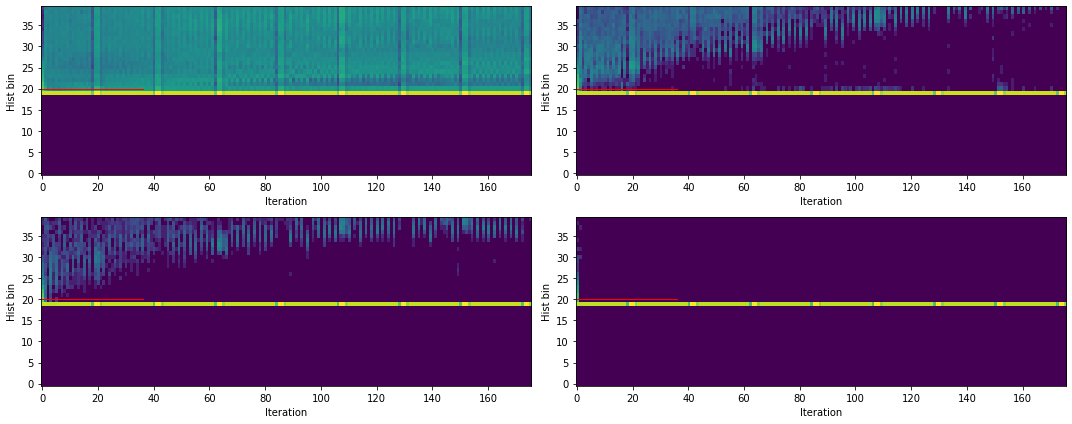

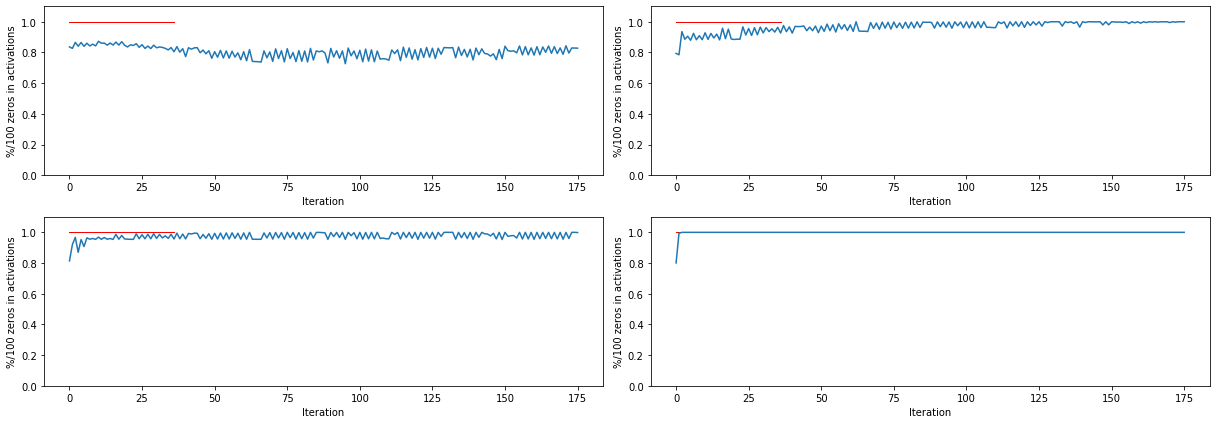

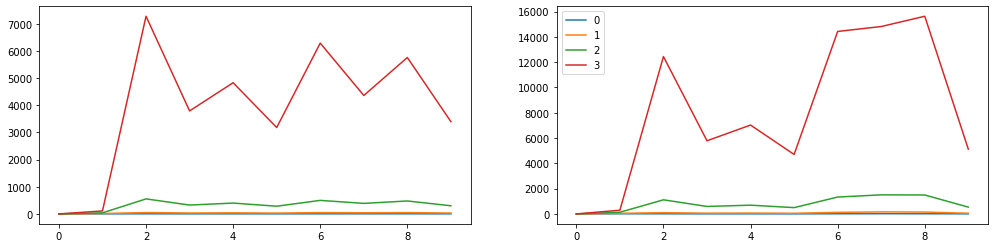

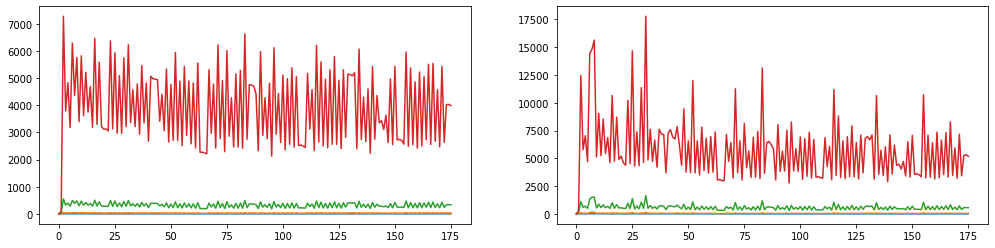

In [46]:
with Hooks(learn.model, append_stats_hist) as hooks:
    learn.fit(8)
    telemetrize(hooks, xlim=2*len(learn.data.train_ds)//bs)

### Scheduler

### Test export

In [ ]:
with torch.no_grad():
    model.eval()
    pred = model(x_test)
    model.train()

In [ ]:
pred = model(x_test)

In [ ]:
pred

In [ ]:
PATH = Path('../data/houseprice/')
# !dir {PATH}  # Windows
# !ls {PATH}

In [ ]:
out = 'submission.csv'
with open(PATH/out, 'w') as f:
    f.write('Id,SalePrice\n')
    for e, p in enumerate(pred, start=1461):
        f.write(f'{e},{p.item()}\n')

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [ ]:
cbfs = [DeviceCallback, Recorder, partial(AvgStatsCallback, avg_deviation), partial(ParamScheduler,'lr', sched)]

#### Setup 1

In [ ]:
learn, run = get_runner(model, data, lr=0.25, cbs=cbfs, loss_func = rmsle)

In [ ]:
init_lin(model, True)

In [ ]:
run.fit(8, learn)

#### Setup 2

In [ ]:
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs, loss_func = rmsle)

In [ ]:
init_lin(model, True)

In [ ]:
run.fit(8, learn)

#### Setup 3